In [82]:
from collections import defaultdict
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyprojroot
import seaborn as sns
import sklearn.metrics
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import searchnets
from searchnets import nets
from searchnets.datasets import VOCDetectionTest
from searchnets.engine.abstract_trainer import AbstractTrainer
from searchnets.transforms.util import get_transforms
from searchnets.utils.general import make_save_path

In [11]:
DATASET_TYPE = 'VOC'
LOSS_FUNCS = ['CE-largest', 'CE-random', 'BCE']

PAD_SIZE = 500

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [52]:
NUM_WORKERS = 4


class VOCTester:
    """class for measuring accuracy of CNNs on test set after training for visual search task"""
    def __init__(self,
                 net_name,
                 model,
                 testset,
                 restore_path,
                 loss_func,
                 batch_size=64,
                 sigmoid_threshold=0.5,
                 device='cuda',
                 num_workers=NUM_WORKERS,
                 data_parallel=False,
                 ):
        self.net_name = net_name

        self.data_parallel = data_parallel
        if data_parallel:
            model = nn.DataParallel(model)

        self.restore_path = restore_path

        best_ckpt_path = restore_path.parent.joinpath(
            restore_path.name + AbstractTrainer.BEST_VAL_ACC_CKPT_SUFFIX
        )
        if not best_ckpt_path.exists():
            ckpt_path = restore_path.parent.joinpath(
                restore_path.name + AbstractTrainer.DEFAULT_CKPT_SUFFIX)
            if not ckpt_path.exists():
                raise ValueError(
                    f'did not find a checkpoint file in restore path: {restore_path}.\n'
                    f'Looked for a checkpoint saved upon best val accuracy: {best_ckpt_path.name} \n'
                    f'and for a checkpoint saved during or at the end of training: {ckpt_path.name}'
                )
            self.ckpt_path_loaded_from = ckpt_path
        else:
            self.ckpt_path_loaded_from = best_ckpt_path

        checkpoint = torch.load(self.ckpt_path_loaded_from)
        model.load_state_dict(checkpoint['model'])
        model.to(device)
        self.model = model
        self.device = device

        self.testset = testset
        self.test_loader = DataLoader(self.testset, batch_size=batch_size,
                                      shuffle=False, num_workers=num_workers,
                                      pin_memory=True)

        self.batch_size = batch_size

        self.sigmoid_threshold = sigmoid_threshold
        self.sigmoid_activation = torch.nn.Sigmoid()
        self.softmax_activation = torch.nn.Softmax()

        self.loss_func = loss_func
            
    @classmethod
    def from_config(cls,
                    net_name,
                    num_classes,
                    **kwargs):
        """factory function that creates instance of Tester from options specified in config.ini file
        
        Parameters
        ----------
        net_name : str
            name of neural network architecture. Used when restoring model, checkpoints, etc.
        kwargs : keyword arguments

        Returns
        -------
        tester : Tester
            instance of class, initialized with passed attributes.
        """
        if net_name == 'alexnet':
            model = nets.alexnet.build(pretrained=False, progress=False, num_classes=num_classes)
        elif net_name == 'VGG16':
            model = nets.vgg16.build(pretrained=False, progress=False, num_classes=num_classes)
        elif net_name == 'CORnet_Z':
            model = nets.cornet.build(pretrained=False, num_classes=num_classes)

        kwargs = dict(**kwargs, net_name=net_name, model=model)
        return cls(**kwargs)

    def test(self):
        """method to test trained model

        Returns
        -------
        acc : float
            accuracy on test set
        pred : numpy.ndarray
            predictions for test set
        """
        self.model.eval()

        total = int(np.ceil(len(self.testset) / self.batch_size))
        # pbar = tqdm(self.test_loader)
        
        # lists of numpy arrays that get concatenated at the end, 
        # save for further analysis if required
        arrays = defaultdict(list)

        # will use with Pandas.DataFrame.from_records() 
        # to make dataframe of test results, where each row is one sample from test set
        test_records = defaultdict(list)

        with torch.no_grad():
            for i, batch in enumerate(self.test_loader):
                # pbar.set_description(f'batch {i} of {total}')

                # ---- get outputs ----
                x_batch, y_true_onehot_batch = batch['img'].to(self.device), batch['target'].to(self.device)
                arrays['y_true_onehot'].append(y_true_onehot_batch.cpu().numpy())
                out_batch = self.model(x_batch)
                # arrays['out'].append(out_batch.cpu().numpy())  # raw output of network

                # ---- pass outputs through activation ---- 
                out_sigmoid_batch = self.sigmoid_activation(out_batch)
                # arrays['out_sigmoid'].append(out_sigmoid_batch.cpu().numpy())
                out_softmax_batch = self.softmax_activation(out_batch)
                # arrays['out_softmax'].append(out_sigmoid_batch.cpu().numpy())

                y_pred_sigmoid_batch = (out_sigmoid_batch > self.sigmoid_threshold).float()
                arrays['y_pred_sigmoid'].append(y_pred_sigmoid_batch.cpu().numpy())  # will use to compute F1 at end
                # compute true positive, false positive, true negative, false negative
                TP = ((y_true_onehot_batch == 1) & (y_pred_sigmoid_batch == 1)).sum(dim=1)
                FP = ((y_true_onehot_batch == 0) & (y_pred_sigmoid_batch == 1)).sum(dim=1)
                TN = ((y_true_onehot_batch == 0) & (y_pred_sigmoid_batch == 0)).sum(dim=1)
                FN = ((y_true_onehot_batch == 1) & (y_pred_sigmoid_batch == 0)).sum(dim=1)

                _, y_pred_softmax_batch = torch.max(out_softmax_batch.data, 1)
                arrays['y_pred_softmax'].append(y_pred_softmax_batch.cpu().numpy())

                y_true_largest_batch = batch['largest'].to(self.device)
                correct_largest_batch = (y_pred_softmax_batch == y_true_largest_batch)
                arrays['correct_largest'].append(correct_largest_batch.cpu().numpy())  # will use to compute acc at end

                y_true_random_batch = batch['random'].to(self.device)
                correct_random_batch = (y_pred_softmax_batch == y_true_random_batch)
                arrays['correct_random'].append(correct_random_batch.cpu().numpy())  # will use to compute acc at end

                # now loop through each sample in batch to add to records; these will be rows in dataframe
#                 index_batch = batch['index']
#                 vsd_score_batch = batch['vsd_score']
#                 rows = zip(
#                     torch.unbind(index_batch),
#                     torch.unbind(vsd_score_batch),
#                     torch.unbind(TP),
#                     torch.unbind(FP),
#                     torch.unbind(TN),
#                     torch.unbind(FN),
#                     torch.unbind(correct_largest_batch),
#                     torch.unbind(correct_random_batch),
#                 )
#                 for row in rows:
#                     for key, value in zip(
#                         ['index', 'vsd_score', 'TP', 'FP', 'TN', 'FN', 'correct_largest', 'correct_random'],
#                         row,
#                     ):
#                         value = value.cpu().numpy().item()
#                         test_records[key].append(value)

        arrays = {k: np.concatenate(v) for k, v in arrays.items()}
        # df_test = pd.DataFrame.from_records(test_records)
                                               
        # compute f1 at end so we don't have to deal with averaging across batches
        f1 = sklearn.metrics.f1_score(y_true=arrays['y_true_onehot'],
                                      y_pred=arrays['y_pred_sigmoid'],
                                      average='macro')
        # do same with other metrics just for consistency
        acc_largest = arrays['correct_largest'].sum() / arrays['correct_largest'].size
        acc_random = arrays['correct_random'].sum() / arrays['correct_random'].size
                        
        return {
            # 'arrays': arrays,
            # 'df_test': df_test,
            'f1': f1,
            'acc_largest': acc_largest,
            'acc_random': acc_random,
        }

In [53]:
def test(cfg):
    # will use with Pandas.DataFrame.from_records() 
    # to make dataframe of test results, where each row is one training replicate
    replicate_records = defaultdict(list)
    
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    print(f'device: {device}')

    assert len(cfg.train.epochs_list) == 1
    epochs = cfg.train.epochs_list[0]

    for net_number in range(1, cfg.train.number_nets_to_train + 1):
        print(f'running tester on replicate {net_number}')
        transform, target_transform = get_transforms(cfg.data.dataset_type, 
                                                     loss_func='BCE',  # we want all classes present, regardless of actual loss function used in training 
                                                     pad_size=cfg.data.pad_size)

        testset = VOCDetectionTest(root=cfg.data.root,
                                   csv_file=cfg.data.csv_file_out,
                                   image_set='trainval',
                                   split='test',
                                   download=True,
                                   )

        restore_path_this_net = make_save_path(cfg.train.save_path, cfg.train.net_name, net_number, epochs)
        
        print(f'Loading model from {restore_path_this_net}')
        tester = VOCTester.from_config(net_name=cfg.train.net_name,
                                       testset=testset,
                                       restore_path=restore_path_this_net,
                                       num_classes=cfg.data.num_classes,
                                       batch_size=cfg.train.batch_size,
                                       device=device,
                                       num_workers=cfg.train.num_workers,
                                       data_parallel=cfg.train.data_parallel,
                                       loss_func=cfg.train.loss_func)

        results_this_replicate = tester.test()
        for k, v in results_this_replicate.items():
            replicate_records[k].append(v)

        # append these once per replicate, each replicate is a row
        replicate_records['net_name'].append(cfg.train.net_name)
        replicate_records['replicate'].append(net_number)
        replicate_records['loss_func'].append(cfg.train.loss_func)

    return replicate_records

In [44]:
VSD_CONFIGS_ROOT = pyprojroot.here('./data/configs/VSD')
VSD_CONFIG_INIS = sorted(VSD_CONFIGS_ROOT.glob('*.ini'))

In [45]:
ALEXNET_VSD_CONFIG_INIS = [vsd_config for vsd_config in VSD_CONFIG_INIS if 'alexnet' in str(vsd_config) and 'transfer' in str(vsd_config)]

In [46]:
CORNET_Z_VSD_CONFIG_INIS = [vsd_config for vsd_config in VSD_CONFIG_INIS if 'CORnet_Z' in str(vsd_config) and 'transfer' in str(vsd_config)]

In [54]:
test_records = defaultdict(list)

for configfile in ALEXNET_VSD_CONFIG_INIS:
    print(f"measuring test on {configfile.name}")
    cfg = searchnets.config.parse_config(configfile)
    replicate_records_this_loss_func = test(cfg)
    for k, v in replicate_records_this_loss_func.items():
        test_records[k].extend(v)  # extend because each value v is a list, not a single item

measuring test on VSD_alexnet_transfer_BCE.ini
device: cuda
running tester on replicate 1
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/checkpoints/VSD_alexnet_transfer_BCE/trained_200_epochs/net_number_1/alexnet_trained_200_epochs_number_1


/home/bart/anaconda3/envs/searchnets-torch/lib/python3.6/site-packages/ipykernel_launcher.py:125: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


running tester on replicate 2
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/checkpoints/VSD_alexnet_transfer_BCE/trained_200_epochs/net_number_2/alexnet_trained_200_epochs_number_2
running tester on replicate 3
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/checkpoints/VSD_alexnet_transfer_BCE/trained_200_epochs/net_number_3/alexnet_trained_200_epochs_number_3
running tester on replicate 4
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/checkpoints/VSD_alexnet_transfer_BCE/trained_200_epochs/net_number_4/alexnet_trained_200_epochs_number_4
running tester on replicate 5
Using downloaded and verified file: /home/bart/Docum

In [ ]:
test_df_alexnet = pd.DataFrame.from_records(test_records)

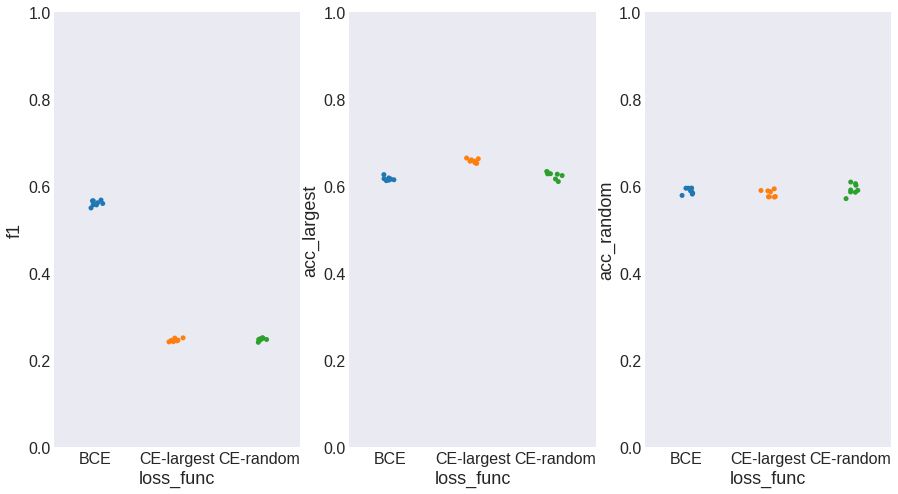

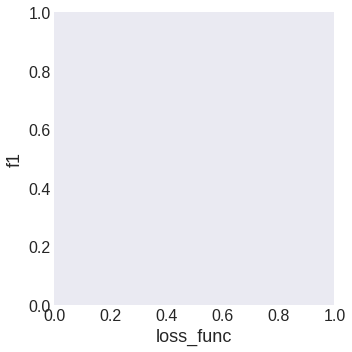

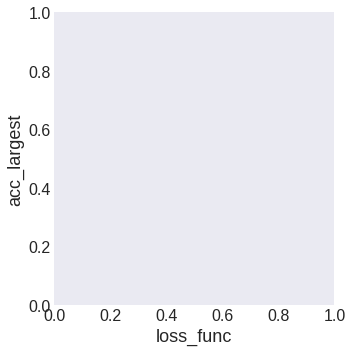

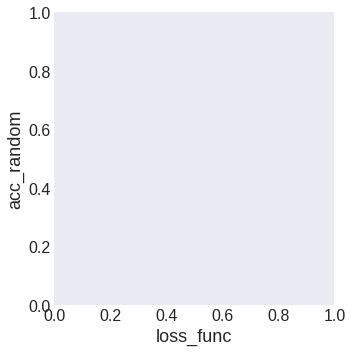

In [92]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
# ax = ax.ravel()

sns.catplot(y='f1', x='loss_func', data=test_df_alexnet, ax=ax[0])
sns.catplot(y='acc_largest', x='loss_func', data=test_df_alexnet, ax=ax[1])
sns.catplot(y='acc_random', x='loss_func', data=test_df_alexnet, ax=ax[2])

for axes in ax:
    axes.set_ylim([0, 1])